In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, seed=123)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b
y_ = tf.placeholder(tf.float32, [None, 10])

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [4]:
def get_images(batch_size, n_iterations):
    return [mnist.train.next_batch(batch_size = batch_size, shuffle=False) for _ in range(n_iterations)]

In [5]:
def train_standard(opt_type, learning_rate, image_set):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # no-minibatch (standard, simple) operation
    #
    minimize = opt.minimize(loss)
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        sess.run(minimize, feed_dict={x: batch[0], y_: batch[1]})
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
    return acc_log, loss_log

In [11]:
def train_minibatch(opt_type, learning_rate, image_set, minibatch_size):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # minibatch operations
    #
    # 0) Retrieve trainable variables
    tvs = tf.trainable_variables() 
    # 1) Create placeholders for the accumulating gradients we'll be storing
    accum_vars = [tf.Variable(tv.initialized_value(),
                  trainable=False) for tv in tvs]
    # 2) Operation to initialize accum_vars to zero
    zero_ops  = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
    # 3) Operation to compute the gradients for one minibatch
    gvs = opt.compute_gradients(loss)
    # 4) Operation to accumulate the gradients in accum_vars
    accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
    # 5) Operation to perform the update (apply gradients)
    apply_ops = opt.apply_gradients([(accum_vars[i], tv) for i, tv 
                                     in enumerate(tf.trainable_variables())])
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        # Make sure gradients are set to 0 before entering minibatch loop
        sess.run(zero_ops)
        # Loop over minibatches and execute accumulate-gradient operation
        for j in range(int(len(image_set) / minibatch_size)):
            sess.run(accum_ops, 
                     feed_dict={x: batch[0][j*minibatch_size:(j+1)*minibatch_size],
                                y_: batch[1][j*minibatch_size:(j+1)*minibatch_size]})

        # Done looping over minibatches. Now apply gradients.
        sess.run(apply_ops)
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})

        #print("in iteration {}".format(i), sess.run(accum_vars))
    return acc_log, loss_log

In [9]:
def compare(batch_size, minibatch_size, n_iterations):

    # Define optimizers (type, learning rate, and name) to be compared
    options = { tf.train.GradientDescentOptimizer : (0.03,  "SGD"),
                tf.train.AdagradOptimizer         : (0.001, "Adagrad"),
                tf.train.AdamOptimizer            : (0.001, "Adam"),
                tf.train.RMSPropOptimizer         : (0.0001,"RMSProp")
              }

    # Load a fixed set of images to run the training on
    image_set = get_images(batch_size=batch_size, n_iterations=n_iterations)

    # Loop over optimizers to compare
    for opt_type, (lr,name) in options.items():
        # Canvas making
        f, (ax0,ax1) = plt.subplots(1,2,figsize=(16,4),sharey=False,facecolor='w')
        f.suptitle('{} Batch {}'.format(name,batch_size), fontsize=20, fontname="Georgia")

        # accuracy plot
        ax0.set_ylabel("accuracy",fontsize=20,fontname="Georgia")
        ax0.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        # loss plot
        ax1.set_ylabel("loss",fontsize=20,fontname="Georgia")
        ax1.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        
        # "standard" training first
        acc_log, loss_log = train_standard  (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set)
        ax0.plot(acc_log,  'r.-', label="No minibatch")
        ax1.plot(loss_log, 'r.-', label="No minibatch")
        
        # "minibatch" training second
        acc_log, loss_log = train_minibatch (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set, 
                                             minibatch_size=minibatch_size)
        ax0.plot(acc_log, 'b', label="Minibatch {}".format(minibatch_size))
        ax1.plot(loss_log,'b', label="Minibatch {}".format(minibatch_size))

        # Show
        ax0.grid()
        ax1.grid()
        ax0.legend(loc=4,fontsize=16)
        ax1.legend(loc=3,fontsize=16)
        plt.show()

For Stochastic Gradient Descent, BATCH_SIZE = 1.

For Batch Gradient Descent, BATCH_SIZE = training dataset size.

For Mini Batch Gradient Decent, 1 << BATCH_SIZE << training dataset size.

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


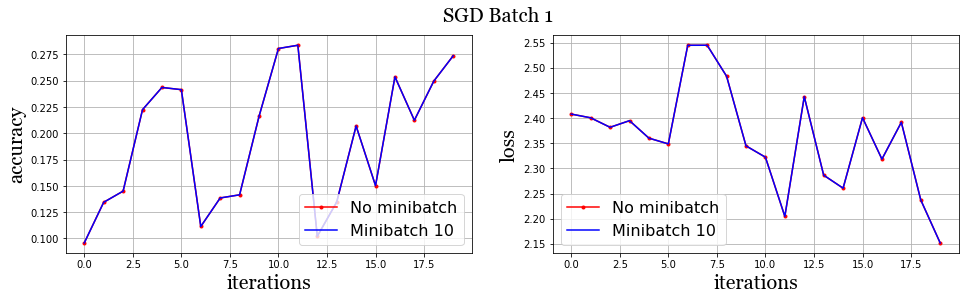

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


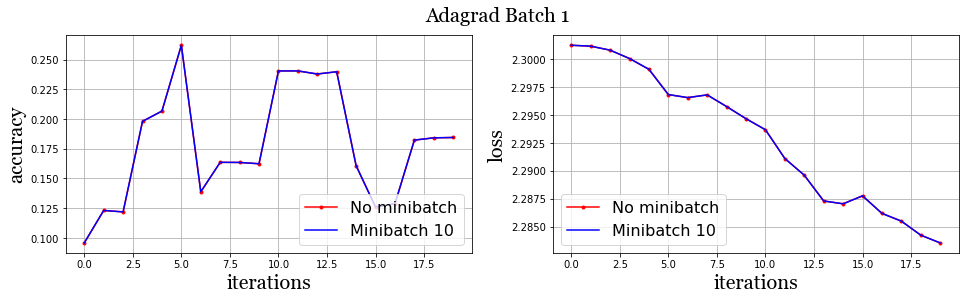

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


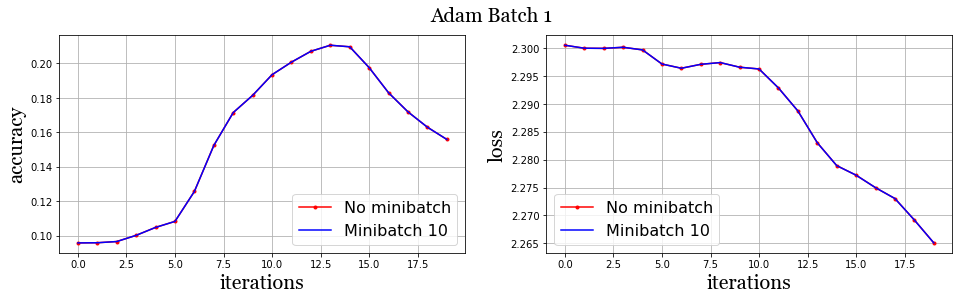

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


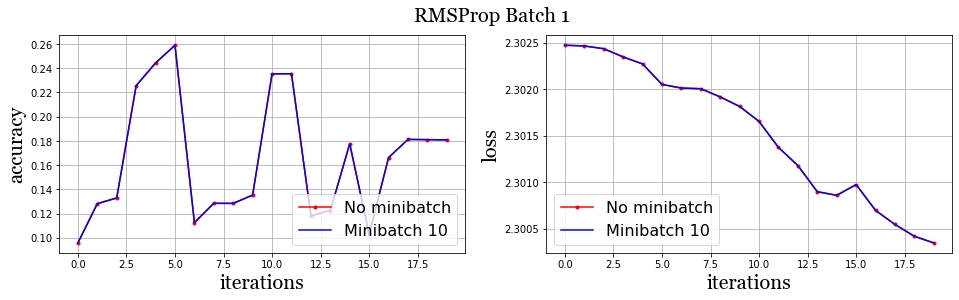

In [27]:
compare( batch_size     = 1,
         minibatch_size = 10,
         n_iterations   = 20)

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


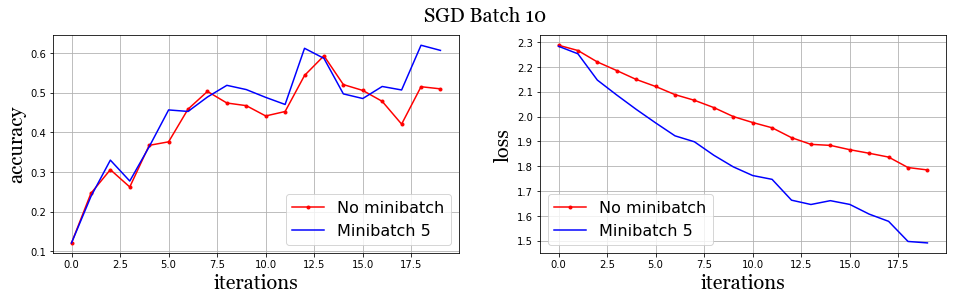

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


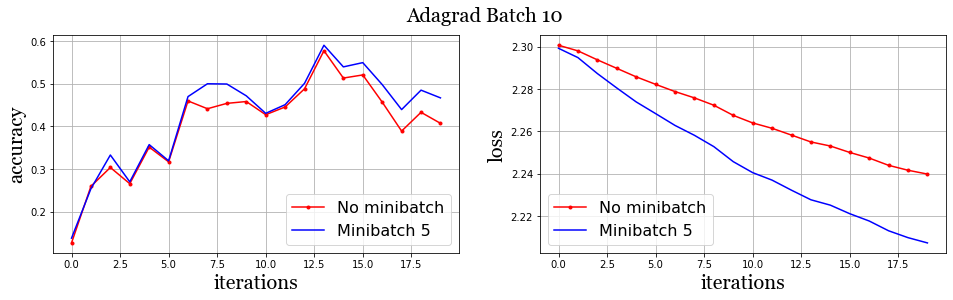

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


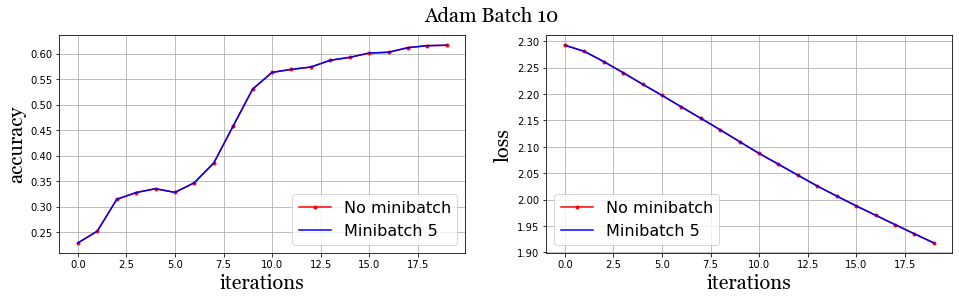

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


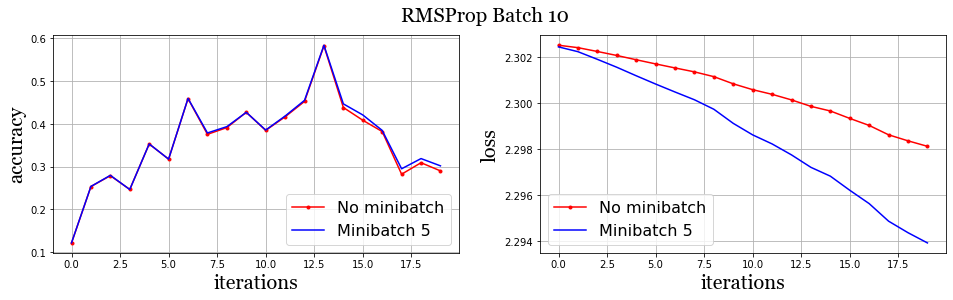

In [28]:
compare( batch_size     = 10,
         minibatch_size = 5,
         n_iterations   = 20)

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


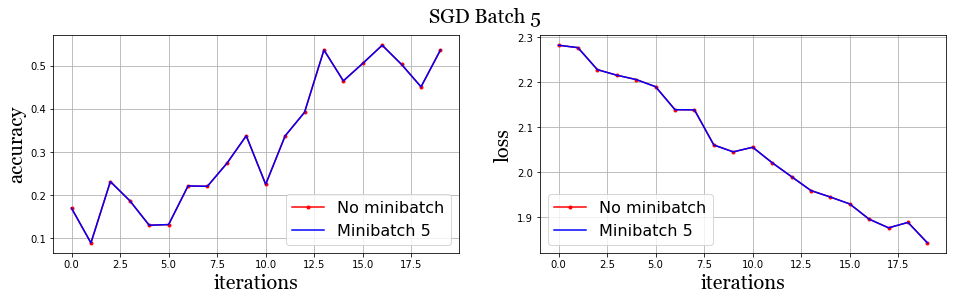

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


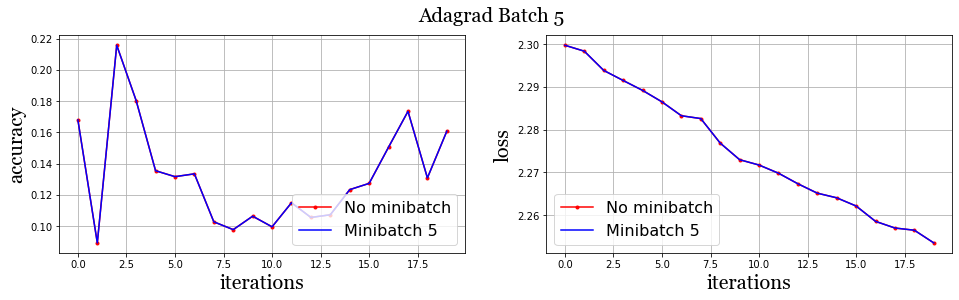

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


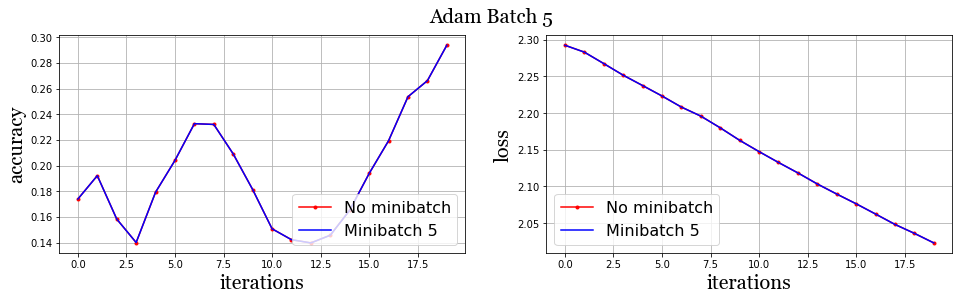

C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Pc\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


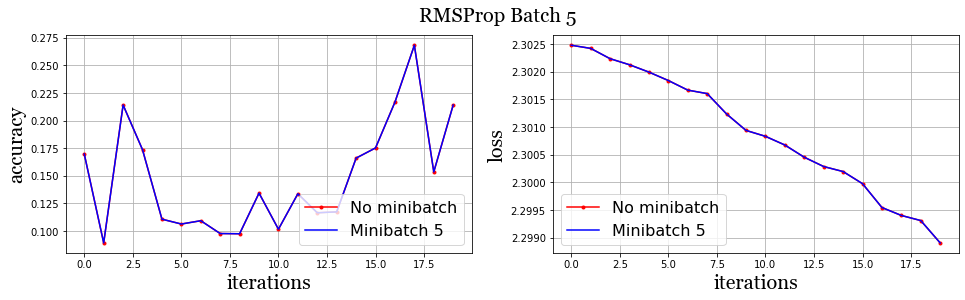

In [29]:
compare( batch_size     = 5,
         minibatch_size = 5,
         n_iterations   = 20)

In [30]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [32]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

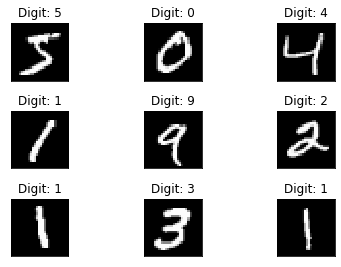

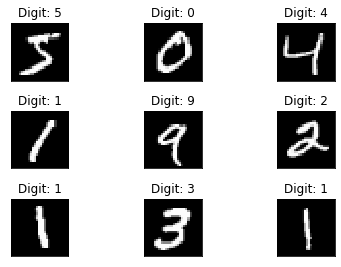

In [33]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

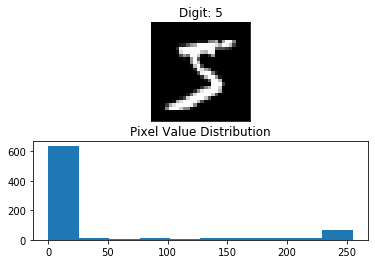

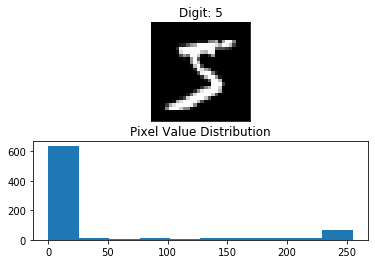

In [34]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(x_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(x_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

In [35]:
# let's print the shape before we reshape and normalize
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalizing the data to help with the training
x_train /= 255
x_test /= 255

# print the final input shape ready for training
print("Train matrix shape", x_train.shape)
print("Test matrix shape", x_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [36]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [37]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/5




60000/60000 [==============================] - 11s 176us/step - loss: 0.2841 - acc: 0.9190 - val_loss: 0.1342 - val_acc: 0.9617
Epoch 2/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.1213 - acc: 0.9645 - val_loss: 0.0960 - val_acc: 0.9708
Epoch 3/5
60000/60000 [==============================] - 7s 121us/step - loss: 0.0848 - acc: 0.9747 - val_loss: 0.0732 - val_acc: 0.9772
Epoch 4/5
60000/60000 [==============================] - 7s 111us/step - loss: 0.0627 - acc: 0.9810 - val_loss: 0.0680 - val_acc: 0.9797
Epoch 5/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.0501 - acc: 0.9850 - val_loss: 0.0599 - val_acc: 0.9809
Saved trained model at keras_mnist.h5 


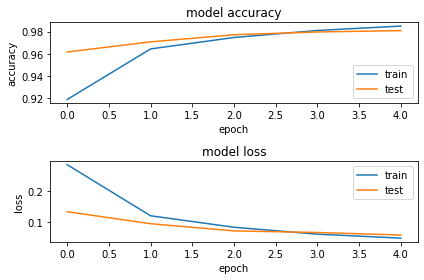

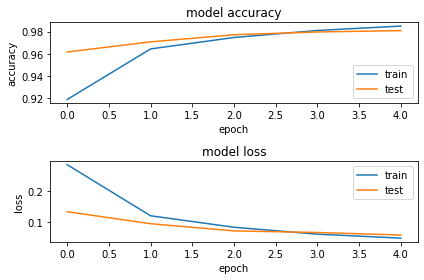

In [39]:
# training the model and saving metrics in history
history = model.fit(x_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1,
          validation_data=(x_test, Y_test))

# saving the model
model_name = 'keras_mnist.h5'
model_path = os.path.join(model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

# References

https://stackoverflow.com/questions/46840539/online-or-batch-training-by-default-in-tensorflow
    
https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
    
http://deeplearnphysics.org/